In [1]:
import math
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import metrics

# Display plots in the notebook
%matplotlib inline

# Plotting parameters 
plt.rcParams['figure.figsize'] = (10, 7)
plt.rcParams['font.size'] = 12

In [2]:
# load files
fileL1 = 'http://localhost:8888/tree/data/L1_87-108mhz.csv'
fileL2 = 'http://localhost:8888/tree/data/L2_87-108mhz.csv'
fileL3 = 'http://localhost:8888/tree/data/L3_87-108mhz.csv'
fileL4 = 'http://localhost:8888/tree/data/L4_87-108mhz.csv'
fileL5 = 'http://localhost:8888/tree/data/L5_87-108mhz.csv'

# column names
col_names = ['ReceptionStart',
             'ReceptionEnd', 'Frequency', 'Center', 'Description', 
             'Notes', 'Protocol', 'Service', 'Callsign', 'ShiftEnabled', 
             'Shift', 'FilterType', 'FilterBandwidth', 'SquelchEnabled',
             'Squelch', 'CWShift', 'TimeoutSeconds', 'MinSignalStrength', 
             'ActualSignalStrength', 'Remarks']

# unwanted columns 
drop_cols = ['ReceptionStart','ReceptionEnd', 'Center', 'Description', 'Notes', 'Protocol', 'Service', 
         'Callsign', 'ShiftEnabled', 'Shift', 'FilterType', 'FilterBandwidth', 'SquelchEnabled',
         'Squelch', 'CWShift', 'TimeoutSeconds', 'MinSignalStrength', 'Remarks']

# function to format data
def formatdf(file, headers, unwanted_col, coordinates):
    rf = pd.read_csv(file, header=0, names=headers, na_filter=False)
    rf = rf.drop(unwanted_col,1)
    rf['Lat'] = coordinates[0]
    rf['Lon'] = coordinates[1]
    rf['Frequency'] = rf['Frequency'] * 0.000001
    return rf

df1 = formatdf(fileL1, col_names, drop_cols, [1.423272, 103.844975])
df2 = formatdf(fileL2, col_names, drop_cols, [1.359603, 103.843286])
df3 = formatdf(fileL3, col_names, drop_cols, [1.385351, 103.745053])
df4 = formatdf(fileL4, col_names, drop_cols, [1.350483, 103.872321])
df5 = formatdf(fileL5, col_names, drop_cols, [1.371094, 103.949197])

In [3]:
# load data on radio stations
f = 'http://localhost:8888/tree/data/RadioStations.xlsx'
RadioStations = pd.read_excel(f)

# drop unwanted columns 
drop_cols = ['p', 'm', 'RDS-PS', 'RDS-PI', 'program', 
         'power', 'dB']

RS = RadioStations.drop(drop_cols, 1).sort_values(['MHz']).reset_index()
RS = RS.drop('index', 1)

In [4]:
# assign respective transmitter distances to the data frame
dflist = [df1, df2, df3, df4, df5]
RSloclist = ['L1', 'L2', 'L3', 'L4', 'L5']

for df, RSloc in zip(dflist, RSloclist):
    for idx, f in df['Frequency'].iteritems():
        for i, mhz in RS['MHz'].iteritems():
            if np.round(f,1) == np.round(mhz, 1):
                df.loc[idx,'TransmitterDistance'] = RS.loc[i, RSloc]
            else:
                pass

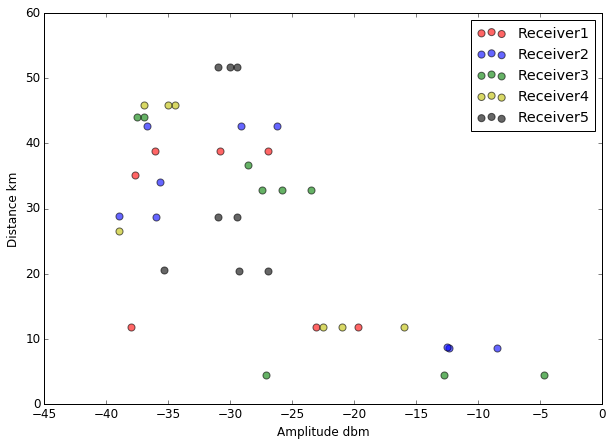

In [5]:
# Visualize data points of selected transmissions
listofFrequenciesDetected = []

for df in dflist:
    df_not_null = df.dropna()
    for idx, f in df_not_null.Frequency.iteritems():
        if f not in listofFrequenciesDetected:
            listofFrequenciesDetected.append(f)
        else:
            pass
    else:
        pass

colors = ['r', 'b', 'g', 'y', 'k']
labels = ['Receiver1', 'Receiver2', 'Receiver3', 'Receiver4', 'Receiver5']

import random
selectedFreqs = random.sample(listofFrequenciesDetected, 10)

fig, ax = plt.subplots()
   
for df, c, l in zip(dflist, colors, labels):
    df_not_null = df.dropna()
    x = []
    y = []
    for f in selectedFreqs:
        X = df_not_null.loc[df['Frequency'] == f]
        x.append(X.ActualSignalStrength.mean())
        y.append(X.TransmitterDistance.mean())
    ax.scatter(x, y, s=50, c=c, alpha=0.6, label=l)
    
plt.xlabel('Amplitude dbm')
plt.ylabel('Distance km')
# Plot the legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

In [6]:
# Create new dataframe with 'Frequency', 'MeanAmplitude', 'Lat', 'Lon', 'Distance'
def find_mean_and_combine(df):
    df_not_null = df.dropna()
    new = df_not_null.groupby(['Frequency', 'TransmitterDistance'], as_index=False).mean()
    new.rename(columns={'ActualSignalStrength':'MeanAmplitude'}, inplace=True)
    return new

rf1 = find_mean_and_combine(df1)
rf2 = find_mean_and_combine(df2)
rf3 = find_mean_and_combine(df3)
rf4 = find_mean_and_combine(df4)
rf5 = find_mean_and_combine(df5)

new_df_list = [rf1, rf2, rf3, rf4, rf5]
rf = pd.concat(new_df_list).reset_index()
rf = rf.drop('index', 1)

In [7]:
# linear regression model

# Features are Frequency, ActualSignalStrength, Latitude and Longitude
X = rf.drop(['TransmitterDistance'], axis=1)

# Labels are TransmitterDistance
y = rf.TransmitterDistance

# fit
linreg = LinearRegression()
linreg.fit(X, y)

# print the coefficients
print linreg.intercept_
print linreg.coef_

feature_cols = ['Frequency', 'MeanAmplitude', 'Lat', 'Lon']
zip(feature_cols, linreg.coef_)

704.307229819
[   0.325409     -1.02370806 -104.39737391   -5.69172246]


[('Frequency', 0.32540900182332744),
 ('MeanAmplitude', -1.0237080598480128),
 ('Lat', -104.39737390781811),
 ('Lon', -5.6917224577960521)]

In [8]:
# define a function that accepts X and y and computes testing RMSE
def train_test_rmse(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    y_pred = linreg.predict(X_test)
    return np.sqrt(mean_squared_error(y_test, y_pred))

In [9]:
train_test_rmse(X,y)

10.979701775770168

In [10]:
# As rmse is very large, i will try with higher order polynomials
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

for d in range(1,5):
    poly = PolynomialFeatures(degree=d)
    X_ = poly.fit_transform(X)
    print train_test_rmse(X_,y)

10.9797017758
11.2743406999
11.3452748641
25.6434587276


In [12]:
# Test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)

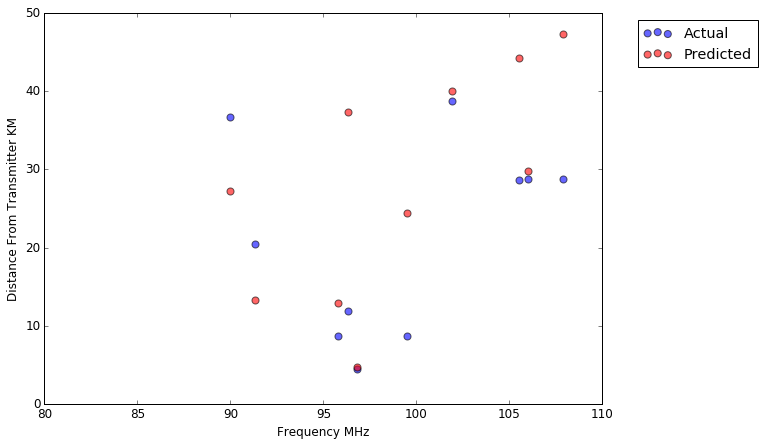

In [13]:
# Visualize Predictions
plt.figure(1)
Actual = plt.scatter(X_test.Frequency[20:30], y_test[20:30], s=50, c='b', alpha=0.6)
Predicted = plt.scatter(X_test.Frequency[20:30], y_pred[20:30], s=50, c='r', alpha=0.6)
plt.ylabel('Distance From Transmitter KM')
plt.xlabel('Frequency MHz')
plt.axis([80,110, 0, 50])
plt.legend([Actual, Predicted], ['Actual', 'Predicted'], bbox_to_anchor=(1.05, 1), loc=2)

In [15]:
# Evaluation 
print 'Mean Absolute Error: ', metrics.mean_absolute_error(y_test, y_pred)
print 'Median Absolute Error: ', metrics.median_absolute_error(y_test, y_pred)
print 'R2 Score: ', metrics.r2_score(y_test, y_pred)

Mean Absolute Error:  8.82437709607
Median Absolute Error:  7.85336585531
R2 Score:  0.428908668719


In [30]:
rf.to_csv(u'C:\\Users\\user\\Desktop\\GA\\SG_DAT_Project\\data\\RF.csv')

In [45]:
# Create new dataframe of unknown transmissions with 'Frequency', 'MeanAmplitude', 'Lat', 'Lon', 'Distance'
def find_mean_and_combine_Un(df):
    df_null = df[df.isnull().any(axis=1)]
    new = df_null.groupby(['Frequency'], as_index=False).mean()
    new.rename(columns={'ActualSignalStrength':'MeanAmplitude'}, inplace=True)
    return new


Urf1 = find_mean_and_combine_Un(df1)
Urf2 = find_mean_and_combine_Un(df2)
Urf3 = find_mean_and_combine_Un(df3)
Urf4 = find_mean_and_combine_Un(df4)
Urf5 = find_mean_and_combine_Un(df5)

new_U_df_list = [Urf1, Urf2, Urf3, Urf4, Urf5]
unknown_rf = pd.concat(new_U_df_list).reset_index()
unknown_rf = unknown_rf.drop('index', 1)
unknown_rf.to_csv(u'C:\\Users\\user\\Desktop\\GA\\SG_DAT_Project\\data\\unknownRF.csv')